- Field	Description
- SaleID	交易ID，唯一编码
- name	汽车交易名称，已脱敏
- regDate	汽车注册日期，例如20160101，2016年01月01日
- model	车型编码，已脱敏
- brand	汽车品牌，已脱敏
- bodyType	车身类型：豪华轿车：0，微型车：1，厢型车：2，大巴车：3，敞篷车：4，双门汽车：5，商务车：6，搅拌车：7
- fuelType	燃油类型：汽油：0，柴油：1，液化石油气：2，天然气：3，混合动力：4，其他：5，电动：6
- gearbox	变速箱：手动：0，自动：1
- power	发动机功率：范围 [ 0, 600 ]
- kilometer	汽车已行驶公里，单位万km
- notRepairedDamage	汽车有尚未修复的损坏：是：0，否：1
- regionCode	地区编码，已脱敏
- seller	销售方：个体：0，非个体：1
- offerType	报价类型：提供：0，请求：1
- creatDate	汽车上线时间，即开始售卖时间
- price	二手车交易价格（预测目标）
- v系列特征	匿名特征，包含v0-14在内15个匿名特征

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import itertools

from IPython.display import Image

from scipy.stats import norm
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [2]:
%matplotlib inline

# 数据读取

In [3]:
# 路径改成自己的
train = pd.read_csv('/home/ach/下载/数据挖掘/used_car_train_20200313.csv', sep=' ')
train.head(2)

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522


In [4]:
# print(train['price'])

In [5]:
test = pd.read_csv('/home/ach/下载/数据挖掘/used_car_testA_20200313.csv', sep=' ')
test.head(2)

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,150000,66932,20111212,222.0,4,5.0,1.0,1.0,313,15.0,...,0.264405,0.1218,0.070899,0.106558,0.078867,-7.050969,-0.854626,4.800151,0.620011,-3.664654
1,150001,174960,19990211,19.0,21,0.0,0.0,0.0,75,12.5,...,0.261745,0.0000,0.096733,0.013705,0.052383,3.679418,-0.729039,-3.796107,-1.541230,-0.757055


In [6]:
# 看下数据集样本数
train.shape, test.shape

((150000, 31), (50000, 30))

# 缺失值分析

In [7]:
# 求空值数量
train.isnull().sum().sort_values(ascending=False).head()
# 发现 
# fuelType    8680
# gearbox     5981
# bodyType    4506
# model          1
# v_14           0

fuelType    8680
gearbox     5981
bodyType    4506
model          1
v_14           0
dtype: int64

In [8]:
# 缺失值分析
def missing_values(df):
    alldata_na = pd.DataFrame(df.isnull().sum(), columns={'missingNum'})
    alldata_na['existNum'] = len(df) - alldata_na['missingNum']
    alldata_na['sum'] = len(df)
    alldata_na['missingRatio'] = alldata_na['missingNum']/len(df)*100
    alldata_na['dtype'] = df.dtypes
    #ascending：默认True升序排列；False降序排列
    alldata_na = alldata_na[alldata_na['missingNum']>0].reset_index().sort_values(by=['missingNum','index'],ascending=[False,True])
    alldata_na.set_index('index',inplace=True)
    return alldata_na

missing_values(train)

,missingNum,existNum,sum,missingRatio,dtype
index,,,,,
fuelType,8680,141320,150000,5.786667,float64
gearbox,5981,144019,150000,3.987333,float64
bodyType,4506,145494,150000,3.004000,float64
model,1,149999,150000,0.000667,float64


In [9]:
# 缺失值分析
def missing_values(df):
    alldata_na = pd.DataFrame(df.isnull().sum(), columns={'missingNum'})
    alldata_na['existNum'] = len(df) - alldata_na['missingNum']
    alldata_na['sum'] = len(df)
    alldata_na['missingRatio'] = alldata_na['missingNum']/len(df)*100
    alldata_na['dtype'] = df.dtypes
    #ascending：默认True升序排列；False降序排列
    alldata_na = alldata_na[alldata_na['missingNum']>0].reset_index().sort_values(by=['missingNum','index'],ascending=[False,True])
    alldata_na.set_index('index',inplace=True)
    return alldata_na

missing_values(test)

,missingNum,existNum,sum,missingRatio,dtype
index,,,,,
fuelType,2893,47107,50000,5.786,float64
gearbox,1910,48090,50000,3.820,float64
bodyType,1413,48587,50000,2.826,float64


# 分类特征分析

In [10]:
# 查看分类特征的类别数量
for i in ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'kilometer',
            'notRepairedDamage', 'regionCode', 'seller', 'offerType']:
    print(i, train[i].nunique())

name 99662
model 248
brand 40
bodyType 8
fuelType 7
gearbox 2
kilometer 13
notRepairedDamage 3
regionCode 7905
seller 2
offerType 1


In [11]:
for i in ['name', 'model', 'brand', 'bodyType', 'fuelType', 'gearbox', 'kilometer',
            'notRepairedDamage', 'regionCode', 'seller', 'offerType']:
    print(i, test[i].nunique())

name 37453
model 247
brand 40
bodyType 8
fuelType 7
gearbox 2
kilometer 13
notRepairedDamage 3
regionCode 6971
seller 1
offerType 1


# 数值统计

In [12]:
train.describe()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
count,150000.000000,150000.000000,1.500000e+05,149999.000000,150000.000000,145494.000000,141320.000000,144019.000000,150000.000000,150000.000000,...,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000,150000.000000
mean,74999.500000,68349.172873,2.003417e+07,47.129021,8.052733,1.792369,0.375842,0.224943,119.316547,12.597160,...,0.248204,0.044923,0.124692,0.058144,0.061996,-0.001000,0.009035,0.004813,0.000313,-0.000688
std,43301.414527,61103.875095,5.364988e+04,49.536040,7.864956,1.760640,0.548677,0.417546,177.168419,3.919576,...,0.045804,0.051743,0.201410,0.029186,0.035692,3.772386,3.286071,2.517478,1.288988,1.038685
min,0.000000,0.000000,1.991000e+07,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.500000,...,0.000000,0.000000,0.000000,0.000000,0.000000,-9.168192,-5.558207,-9.639552,-4.153899,-6.546556
25%,37499.750000,11156.000000,1.999091e+07,10.000000,1.000000,0.000000,0.000000,0.000000,75.000000,12.500000,...,0.243615,0.000038,0.062474,0.035334,0.033930,-3.722303,-1.951543,-1.871846,-1.057789,-0.437034
50%,74999.500000,51638.000000,2.003091e+07,30.000000,6.000000,1.000000,0.000000,0.000000,110.000000,15.000000,...,0.257798,0.000812,0.095866,0.057014,0.058484,1.624076,-0.358053,-0.130753,-0.036245,0.141246
75%,112499.250000,118841.250000,2.007111e+07,66.000000,13.000000,3.000000,1.000000,0.000000,150.000000,15.000000,...,0.265297,0.102009,0.125243,0.079382,0.087491,2.844357,1.255022,1.776933,0.942813,0.680378
max,149999.000000,196812.000000,2.015121e+07,247.000000,39.000000,7.000000,6.000000,1.000000,19312.000000,15.000000,...,0.291838,0.151420,1.404936,0.160791,0.222787,12.357011,18.819042,13.847792,11.147669,8.658418


# 数据分布
-目标值呈现右偏分布，所以容易收到极大值影响

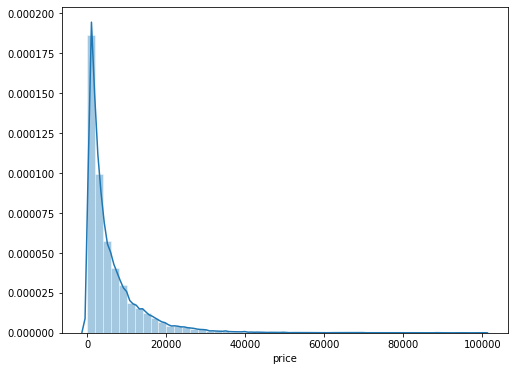

In [13]:
# 目标值分布，右偏分布
fig, ax = plt.subplots(figsize=(8, 6))
sns.set_style("white")
sns.distplot(train['price'])

- 需要删除：SaleID
- 数值型：name power kilometer price V系列 
- 日期型：regDate creatDate
- 分类型： model brand bodyType fuelType gearbox notRepairedDamage regionCode seller offerType 

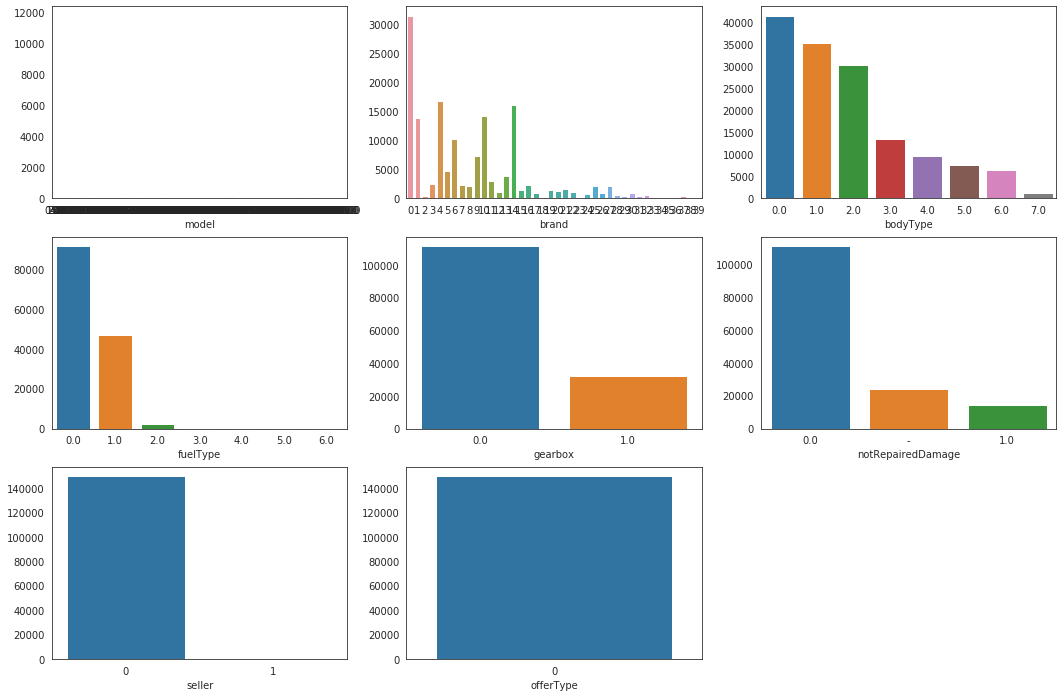

In [14]:
# 删除多余的图表
def trim_axs(axs, N):
    """
    Reduce *axs* to *N* Axes. All further Axes are removed from the figure.
    """
    axs = axs.flat
    for ax in axs[N:]:
        ax.remove()
    return axs[:N]
#分类特征分布
category_columns = ['model','brand', 'bodyType', 'fuelType', 'gearbox', 'notRepairedDamage', 'seller','offerType',]

cols = 3
rows = len(category_columns) // cols + 1

fig, axs = plt.subplots(rows, cols, figsize=(18, 12))
axs = trim_axs(axs, len(category_columns))

for ax, col in zip(axs, category_columns):
    feature_count = train[col].value_counts()
    feature_count.index.name = col
    sns.barplot(x=feature_count.index, y=feature_count.values, ax=ax)

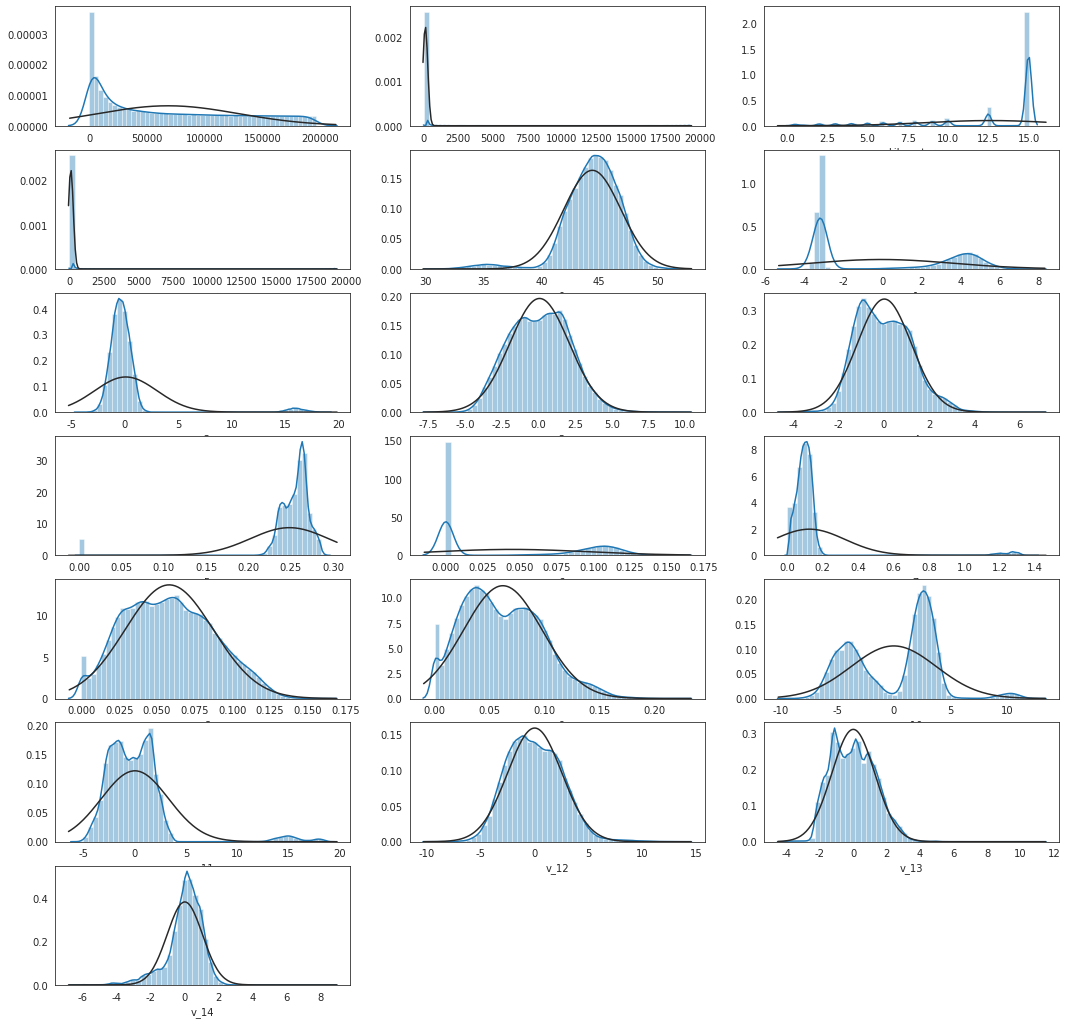

In [15]:
# 数值特征分布
dense_features = ['name', 'power', 'kilometer','power', 'v_0', 'v_1', 'v_2', 'v_3', 'v_4', 'v_5', 'v_6', 'v_7', 'v_8',
                  'v_9', 'v_10', 'v_11', 'v_12', 'v_13', 'v_14']
cols = 3
rows = len(dense_features) // cols + 1

fig, axs = plt.subplots(rows, cols, figsize=(18, 18))
axs = trim_axs(axs, len(dense_features))

for ax, col in zip(axs, dense_features):
    sns.distplot(train[col], fit=norm, ax=ax)
    plt.xlabel(col)

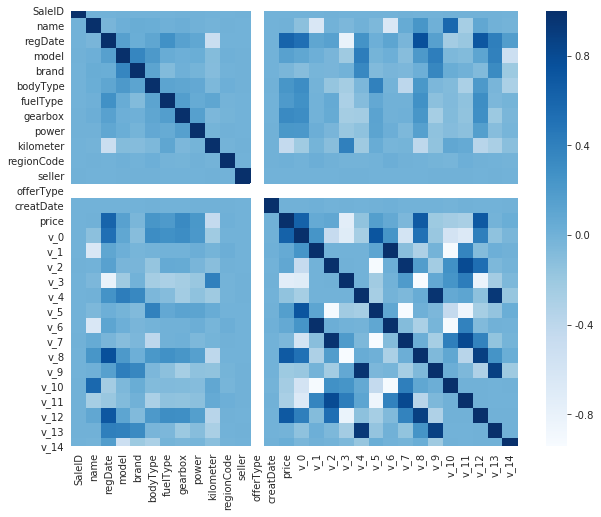

In [16]:
# 查看特征相关系数
corr = train.corr()
plt.subplots(figsize=(10, 8))
sns.heatmap(corr,cmap="Blues")

- Field	Description
- SaleID	交易ID，唯一编码
- name	汽车交易名称，已脱敏
- regDate	汽车注册日期，例如20160101，2016年01月01日
- model	车型编码，已脱敏
- brand	汽车品牌，已脱敏
- bodyType	车身类型：豪华轿车：0，微型车：1，厢型车：2，大巴车：3，敞篷车：4，双门汽车：5，商务车：6，搅拌车：7
- fuelType	燃油类型：汽油：0，柴油：1，液化石油气：2，天然气：3，混合动力：4，其他：5，电动：6
- gearbox	变速箱：手动：0，自动：1
- power	发动机功率：范围 [ 0, 600 ]
- kilometer	汽车已行驶公里，单位万km
- notRepairedDamage	汽车有尚未修复的损坏：是：0，否：1
- regionCode	地区编码，已脱敏
- seller	销售方：个体：0，非个体：1
- offerType	报价类型：提供：0，请求：1
- creatDate	汽车上线时间，即开始售卖时间
- price	二手车交易价格（预测目标）
- v系列特征	匿名特征，包含v0-14在内15个匿名特征

- name和v1，v6负相关，和v10正相关
- regdate和kilometer，v3有关系
- v3和price有关系

# 日期型数据分析

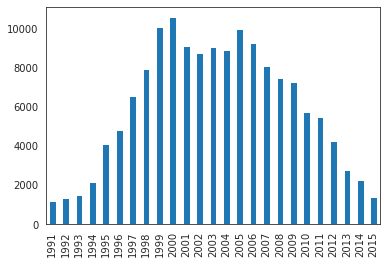

In [17]:
# 注册日期年份
train['regDate'].astype(str).map(lambda x:x[:4]).value_counts().sort_index().plot.bar()

In [18]:
train.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


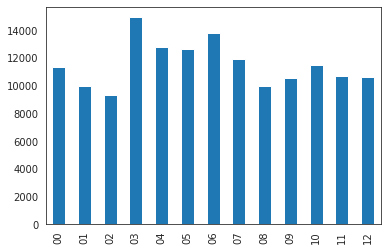

In [19]:
# 注册日期月份
train['regDate'].astype(str).map(lambda x:x[4:6]).value_counts().sort_index().plot.bar()

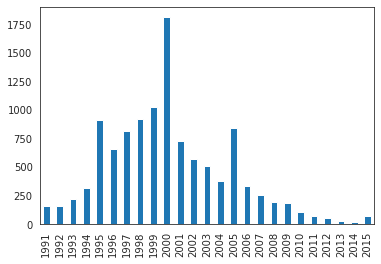

In [22]:
# 00月份的年份分布
month00 = train[train['regDate'].astype(str).map(lambda x:x[4:6] == '00')]
month00['regDate'].astype(str).map(lambda x:x[:4]).value_counts().sort_index().plot.bar()

In [23]:
# all_features.loc[all_features['notRepairedDamage'] == '-'] = 2

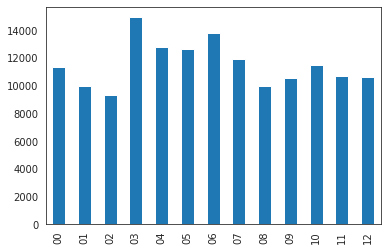

In [24]:
# 注册日期月份
train['regDate'].astype(str).map(lambda x:x[4:6]).value_counts().sort_index().plot.bar()

In [25]:
# 上线日期年份
train['creatDate'].astype(str).map(lambda x:x[:4]).value_counts().sort_index()

2015        18
2016    149982
Name: creatDate, dtype: int64

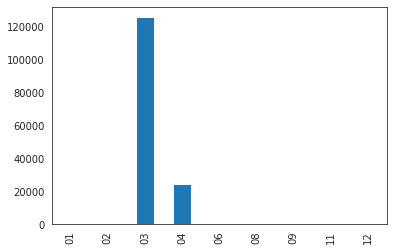

In [26]:
# 上线日期月份
train['creatDate'].astype(str).map(lambda x:x[4:6]).value_counts().sort_index().plot.bar()

#  特征工程
- 处理倾斜特征,进行log处


In [25]:
# 目标值做log处理,如果回归型的，不能使用price做偏移
train['price'] = np.log1p(train['price'])

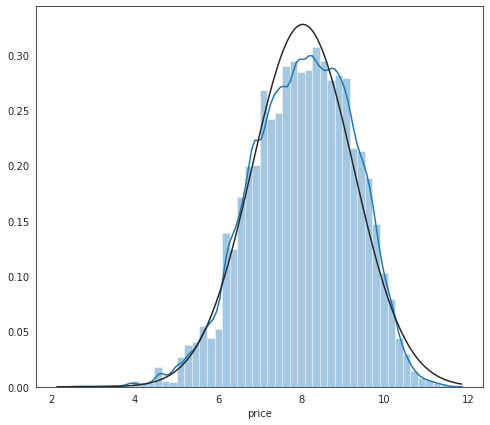

In [26]:
# 查看转化后的分布，有点正态的感觉了
fig, ax = plt.subplots(figsize=(8, 7))
sns.distplot(train['price'], fit=norm)

# 异常值处理


In [27]:
# 删除部分异常值
train.drop(train[train['price'] < 4].index, inplace=True)

In [28]:
# 超过边界部分进行限制
train['power'] = train['power'].map(lambda x: 600 if x>600 else x)
test['power'] = test['power'].map(lambda x: 600 if x>600 else x)

In [29]:
# 整合训练集测试集以便后续特征工程
train_labels = train['price'].reset_index(drop=True)
train_features = train.drop(['price'], axis=1)
test_features = test
all_features = pd.concat([train_features, test_features]).reset_index(drop=True)

# 缺失值处理
- 填充缺失值通常使用均值、中位数或者常见的值进行填充，也可以使用插值补全

In [30]:
# 根据最常出现填充，都是零，也可以根据其他来填充，不是瞎填的。。
# def fill_missing(df):
#     df['fuelType'] = df['fuelType'].fillna(df['fuelType'].median())
#     df['gearbox'] = df['gearbox'].fillna(df['gearbox'].median())
#     df['bodyType'] = df['bodyType'].fillna(df['bodyType'].median())
#     df['model'] = df['model'].fillna(df['model'].median())
def fill_missing(df):
    df['fuelType'] = df['fuelType'].fillna(df['fuelType'].mean())
    df['gearbox'] = df['gearbox'].fillna(df['gearbox'].mean())
    df['bodyType'] = df['bodyType'].fillna(df['bodyType'].mean())
    df['model'] = df['model'].fillna(df['model'].mean())
    return df
all_features = fill_missing(all_features)

In [30]:
# 最后检查空值数量
all_features.isnull().sum().head()

SaleID     0
name       0
regDate    0
model      1
brand      0
dtype: int64

In [31]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 30 columns):
SaleID               200000 non-null int64
name                 200000 non-null int64
regDate              200000 non-null int64
model                199999 non-null float64
brand                200000 non-null int64
bodyType             194081 non-null float64
fuelType             188427 non-null float64
gearbox              192109 non-null float64
power                200000 non-null int64
kilometer            200000 non-null float64
notRepairedDamage    200000 non-null object
regionCode           200000 non-null int64
seller               200000 non-null int64
offerType            200000 non-null int64
creatDate            200000 non-null int64
v_0                  200000 non-null float64
v_1                  200000 non-null float64
v_2                  200000 non-null float64
v_3                  200000 non-null float64
v_4                  200000 non-null float64
v_5     

In [32]:
all_features.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


In [33]:
all_features['notRepairedDamage'].value_counts()

0.0    148610
-       32355
1.0     19035
Name: notRepairedDamage, dtype: int64

In [34]:
# # 将-替换为2
# for i in range(len(all_features)):
#       if str(all_features.loc[i]['notRepairedDamage'])=='-':
#             all_features.loc[i,'notRepairedDamage']='2'
#             print(1)

# #     print(all_features.loc[i]['notRepairedDamage'])
# all_features.loc[all_features['notRepairedDamage'] == '-'].index
# data.loc[data['Y'] == 'F'] = 0
all_features['notRepairedDamage']=all_features['notRepairedDamage'].replace('-',2)

In [35]:
all_features['notRepairedDamage'].value_counts()

0.0    148610
2       32355
1.0     19035
Name: notRepairedDamage, dtype: int64

In [36]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 30 columns):
SaleID               200000 non-null int64
name                 200000 non-null int64
regDate              200000 non-null int64
model                199999 non-null float64
brand                200000 non-null int64
bodyType             194081 non-null float64
fuelType             188427 non-null float64
gearbox              192109 non-null float64
power                200000 non-null int64
kilometer            200000 non-null float64
notRepairedDamage    200000 non-null object
regionCode           200000 non-null int64
seller               200000 non-null int64
offerType            200000 non-null int64
creatDate            200000 non-null int64
v_0                  200000 non-null float64
v_1                  200000 non-null float64
v_2                  200000 non-null float64
v_3                  200000 non-null float64
v_4                  200000 non-null float64
v_5     

In [37]:
#all_features['regMonth'] = all_features['regDate'].map(lambda x:int(str(x)[4:6]))
#print(all_features['regDate'])
all_features.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_5,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.235676,0.101988,0.129549,0.022816,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.264777,0.121004,0.135731,0.026597,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.251410,0.114912,0.165147,0.062173,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.274293,0.110300,0.121964,0.033395,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.228036,0.073205,0.091880,0.078819,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482


# 数据类型转换

In [42]:
#model brand bodyType fuelType gearbox notRepairedDamage regionCode seller offerType
# 处理完
def data_astype(df):
    # string
#     df['SaleID'] = df['SaleID'].astype(int).astype(str)
#     df['name'] = df['name'].astype(int).astype(str)
#     df['model'] = df['model'].astype(str)
#     df['brand'] = df['brand'].astype(str)
#     df['bodyType'] = df['bodyType'].astype(str)
#     df['fuelType'] = df['fuelType'].astype(str)
#     df['gearbox'] = df['gearbox'].astype(str)
#     df['notRepairedDamage'] = df['notRepairedDamage'].astype(str)
#     df['regionCode'] = df['regionCode'].astype(int).astype(str)
#     df['seller'] = df['seller'].astype(int).astype(str)
#     df['offerType'] = df['offerType'].astype(int).astype(str)
    df['SaleID'] = df['SaleID'].astype('int')
    df['name'] = df['name'].astype('int')
    df['model'] = df['model'].astype('float')
#      df['model'] = df['model'].astype('int')
    df['brand'] = df['brand'].astype('int')
#     df['bodyType'] = df['bodyType'].astype('int')
    df['bodyType'] = df['bodyType'].astype('float')
#     df['fuelType'] = df['fuelType'].astype('int')
    df['fuelType'] = df['fuelType'].astype('float')
#     df['gearbox'] = df['gearbox'].astype('int')
    df['gearbox'] = df['gearbox'].astype('float')
    df['notRepairedDamage'] = df['notRepairedDamage'].astype('float64')
    df['regionCode'] = df['regionCode'].astype('int')
    df['seller'] = df['seller'].astype('int')
    df['offerType'] = df['offerType'].astype('int')
#     df['regDate'] = df['regDate'].astype('str')
#     df['creatDate'] = df['creatDate'].astype('str')
    return df
all_features = data_astype(all_features)

In [43]:
all_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 30 columns):
SaleID               200000 non-null int64
name                 200000 non-null int64
regDate              200000 non-null int64
model                199999 non-null float64
brand                200000 non-null int64
bodyType             194081 non-null float64
fuelType             188427 non-null float64
gearbox              192109 non-null float64
power                200000 non-null int64
kilometer            200000 non-null float64
notRepairedDamage    200000 non-null float64
regionCode           200000 non-null int64
seller               200000 non-null int64
offerType            200000 non-null int64
creatDate            200000 non-null int64
v_0                  200000 non-null float64
v_1                  200000 non-null float64
v_2                  200000 non-null float64
v_3                  200000 non-null float64
v_4                  200000 non-null float64
v_5    

# 日期型数据处理
- 提取日期中的年份和月份，方便后续使用

In [44]:
# 提取年份
all_features['regYear'] = all_features['regDate'].map(lambda x:int(str(x)[:4]))
all_features['createYear'] = all_features['creatDate'].map(lambda x:int(str(x)[:4]))
# 提取月份
all_features['regMonth'] = all_features['regDate'].map(lambda x:int(str(x)[4:6]))
all_features['createMonth'] = all_features['creatDate'].map(lambda x:int(str(x)[4:6]))

In [45]:
all_features.head()

,SaleID,name,regDate,model,brand,bodyType,fuelType,gearbox,power,kilometer,...,v_9,v_10,v_11,v_12,v_13,v_14,regYear,createYear,regMonth,createMonth
0,0,736,20040402,30.0,6,1.0,0.0,0.0,60,12.5,...,0.097462,-2.881803,2.804097,-2.420821,0.795292,0.914762,2004,2016,4,4
1,1,2262,20030301,40.0,1,2.0,0.0,0.0,0,15.0,...,0.020582,-4.900482,2.096338,-1.030483,-1.722674,0.245522,2003,2016,3,3
2,2,14874,20040403,115.0,15,1.0,0.0,0.0,163,12.5,...,0.027075,-4.846749,1.803559,1.565330,-0.832687,-0.229963,2004,2016,4,4
3,3,71865,19960908,109.0,10,0.0,0.0,1.0,193,15.0,...,0.000000,-4.509599,1.285940,-0.501868,-2.438353,-0.478699,1996,2016,9,3
4,4,111080,20120103,110.0,5,1.0,0.0,0.0,68,5.0,...,0.121534,-1.896240,0.910783,0.931110,2.834518,1.923482,2012,2016,1,3


# 新特征创建

In [46]:
# 计算上线日期与注册日期想差月份数
all_features['months'] = (all_features['createYear']-all_features['regYear'])*12+(all_features['createMonth']-all_features['regMonth'])
# 查看月份数统计值
all_features['months'].describe()

count    200000.000000
mean        149.022345
std          64.719529
min           3.000000
25%         100.000000
50%         150.000000
75%         198.000000
max         304.000000
Name: months, dtype: float64

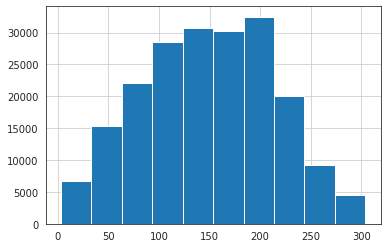

In [47]:
# 月份数分布图
all_features['months'].hist()

# 编码分类变量

In [48]:
# 先删除掉一些不要的特征
all_features = all_features.drop(['SaleID', 'name', 'regDate','seller',
                                  'offerType', 'regionCode', 'regYear',
                                  'createYear', 'regMonth', 'createMonth','creatDate'], axis=1)
# 这里是否要删除更多？

In [49]:
all_features.dtypes

model                float64
brand                  int64
bodyType             float64
fuelType             float64
gearbox              float64
power                  int64
kilometer            float64
notRepairedDamage    float64
v_0                  float64
v_1                  float64
v_2                  float64
v_3                  float64
v_4                  float64
v_5                  float64
v_6                  float64
v_7                  float64
v_8                  float64
v_9                  float64
v_10                 float64
v_11                 float64
v_12                 float64
v_13                 float64
v_14                 float64
months                 int64
dtype: object

In [50]:
corr = all_features.corr()
corr

,model,brand,bodyType,fuelType,gearbox,power,kilometer,notRepairedDamage,v_0,v_1,...,v_6,v_7,v_8,v_9,v_10,v_11,v_12,v_13,v_14,months
model,1.000000,0.359104,0.207812,0.047617,0.017709,0.082132,-0.090117,-0.057744,0.089762,0.018999,...,0.014664,-0.098971,0.211644,0.422974,-0.057302,-0.078254,0.111384,0.399993,-0.514118,-0.149895
brand,0.359104,1.000000,0.115515,-0.081403,0.012094,-0.055554,-0.096258,-0.001179,-0.102369,-0.025154,...,-0.030787,-0.051172,0.013162,0.352899,0.043111,0.007798,-0.073050,0.321201,-0.207455,-0.032210
bodyType,0.207812,0.115515,1.000000,0.117478,0.098796,0.198244,-0.053676,-0.026333,0.302335,-0.012458,...,-0.011748,-0.399209,0.220895,-0.051599,-0.080364,-0.294371,0.209838,-0.030378,-0.288091,-0.101884
fuelType,0.047617,-0.081403,0.117478,1.000000,0.173669,0.150271,0.097273,-0.041078,0.281550,-0.000780,...,0.003421,0.001734,0.280719,-0.130368,-0.077178,-0.136669,0.304458,-0.049985,-0.019719,-0.279948
gearbox,0.017709,0.012094,0.098796,0.173669,1.000000,0.403099,-0.047943,-0.055988,0.307141,-0.003808,...,0.002762,0.013979,0.238473,-0.259836,-0.080819,-0.144923,0.292438,-0.205299,-0.042895,-0.144245
power,0.082132,-0.055554,0.198244,0.150271,0.403099,1.000000,-0.035291,-0.212830,0.544866,0.077070,...,0.082001,-0.148413,0.391192,-0.350727,-0.248181,-0.297133,0.411946,-0.257108,-0.068589,-0.253608
kilometer,-0.090117,-0.096258,-0.053676,0.097273,-0.047943,-0.035291,1.000000,0.106773,-0.227991,-0.023855,...,-0.026345,-0.016783,-0.406647,-0.149335,0.085644,0.067627,-0.369887,-0.283769,-0.117791,0.490144
notRepairedDamage,-0.057744,-0.001179,-0.026333,-0.041078,-0.055988,-0.212830,0.106773,1.000000,-0.352183,-0.200980,...,-0.196823,0.243081,-0.193481,-0.001456,0.308547,0.194349,-0.144626,-0.072701,-0.039372,0.231649
v_0,0.089762,-0.102369,0.302335,0.281550,0.307141,0.544866,-0.227991,-0.352183,1.000000,0.243649,...,0.242587,-0.579968,0.517134,-0.190289,-0.580749,-0.665110,0.421745,-0.138920,-0.039176,-0.531323
v_1,0.018999,-0.025154,-0.012458,-0.000780,-0.003808,0.077070,-0.023855,-0.200980,0.243649,1.000000,...,0.999417,-0.108640,-0.299219,-0.007473,-0.922389,0.374752,-0.086916,0.017650,0.002003,-0.106454


In [51]:
feature_group = list(itertools.combinations(corr.columns, 2))
feature_group

[('model', 'brand'),
 ('model', 'bodyType'),
 ('model', 'fuelType'),
 ('model', 'gearbox'),
 ('model', 'power'),
 ('model', 'kilometer'),
 ('model', 'notRepairedDamage'),
 ('model', 'v_0'),
 ('model', 'v_1'),
 ('model', 'v_2'),
 ('model', 'v_3'),
 ('model', 'v_4'),
 ('model', 'v_5'),
 ('model', 'v_6'),
 ('model', 'v_7'),
 ('model', 'v_8'),
 ('model', 'v_9'),
 ('model', 'v_10'),
 ('model', 'v_11'),
 ('model', 'v_12'),
 ('model', 'v_13'),
 ('model', 'v_14'),
 ('model', 'months'),
 ('brand', 'bodyType'),
 ('brand', 'fuelType'),
 ('brand', 'gearbox'),
 ('brand', 'power'),
 ('brand', 'kilometer'),
 ('brand', 'notRepairedDamage'),
 ('brand', 'v_0'),
 ('brand', 'v_1'),
 ('brand', 'v_2'),
 ('brand', 'v_3'),
 ('brand', 'v_4'),
 ('brand', 'v_5'),
 ('brand', 'v_6'),
 ('brand', 'v_7'),
 ('brand', 'v_8'),
 ('brand', 'v_9'),
 ('brand', 'v_10'),
 ('brand', 'v_11'),
 ('brand', 'v_12'),
 ('brand', 'v_13'),
 ('brand', 'v_14'),
 ('brand', 'months'),
 ('bodyType', 'fuelType'),
 ('bodyType', 'gearbox'),
 (

In [52]:
# 删除相关性高的变量
def filter_corr(corr, cutoff=0.8):
    cols = []
    for i,j in feature_group:
        if corr.loc[i, j] > cutoff:
            i_avg = corr[i][corr[i] != 1].mean()
            j_avg = corr[j][corr[j] != 1].mean()
            if i_avg >= j_avg:
                cols.append(i)
            else:
                cols.append(j)
    return cols
# 相关系数高的组合去掉平均相关系数高的那个
drop_cols = filter_corr(corr, cutoff=0.8)
all_features = all_features.drop(drop_cols, axis=1)

In [53]:
# 编码分类变量
all_features = pd.get_dummies(all_features).reset_index(drop=True)
all_features.shape

(200000, 18)

# 训练集和测试集处理


In [54]:
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
X.shape, train_labels.shape, X_test.shape

((150000, 18), (150000,), (50000, 18))

# 模型训练一：岭回归

In [69]:
# 交叉验证
# K折交叉验证
kf = KFold(n_splits=10, random_state=15, shuffle=True)
# 定义评测指标
def cv_mae(model, X):
    mae = -cross_val_score(model, X, train_labels, scoring='neg_mean_absolute_error')
    return mae

In [51]:
# 定义模型
lr = LinearRegression()
# 查看交叉验证分数
score = cv_mae(lr, X)
score

/home/ach/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


array([ 0.18931021, 17.17185833,  0.19025173])

In [52]:
score.mean()

5.85047342391199

In [53]:
lr.fit(X, train_labels)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [54]:
# 查看R的平方
lr.score(X, train_labels)

0.9391544256451299

- 模型预测

In [55]:
# 没有log处理前的MAE
mean_absolute_error(np.expm1(train_labels), np.expm1(lr.predict(X)))

964.3482628397962

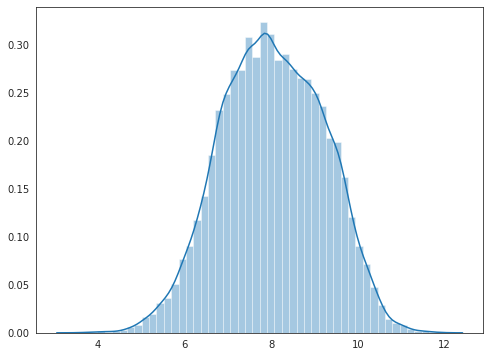

In [56]:
# 查看预测结果
fig, ax = plt.subplots(figsize=(8, 6))
sns.distplot(lr.predict(X_test))

In [57]:
# 预测结果
submission = test[['SaleID']].copy()
submission['price'] = np.expm1(lr.predict(X_test))
submission.shape

(50000, 2)

In [59]:
submission.to_csv('submission.csv', index=False)

# 训练模型二：xgb

In [55]:
## 基础工具
import numpy as np
import pandas as pd
import warnings
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.special import jn
from IPython.display import display, clear_output
import time

warnings.filterwarnings('ignore')
%matplotlib inline

## 模型预测的
from sklearn import linear_model
from sklearn import preprocessing
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor

## 数据降维处理的
from sklearn.decomposition import PCA,FastICA,FactorAnalysis,SparsePCA

import lightgbm as lgb
import xgboost as xgb

## 参数搜索和评价的
from sklearn.model_selection import GridSearchCV,cross_val_score,StratifiedKFold,train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [56]:
print(train_labels)

0         1850
1         3600
2         6222
3         2400
4         5200
          ... 
149995    5900
149996    9500
149997    7500
149998    4999
149999    4700
Name: price, Length: 150000, dtype: int64


In [57]:
## xgb-Model
xgr = xgb.XGBRegressor(n_estimators=120, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #,objective ='reg:squarederror'
X = all_features.iloc[:len(train_labels), :]
X_test = all_features.iloc[len(train_labels):, :]
# X.shape, train_labels.shape, X_test.shape
X_data = X
Y_data = train_labels
# print(Y_data)
# print(X_data.shape)
# print(Y_data.shape)
scores_train = []
scores = []

## 5折交叉验证方式
sk=StratifiedKFold(n_splits=5,shuffle=True,random_state=0)
for train_ind,val_ind in sk.split(X_data,Y_data):
    
    train_x=X_data.iloc[train_ind].values
    train_y=Y_data.iloc[train_ind]
    val_x=X_data.iloc[val_ind].values
    val_y=Y_data.iloc[val_ind]
    
    xgr.fit(train_x,train_y)
    pred_train_xgb=xgr.predict(train_x)
    pred_xgb=xgr.predict(val_x)
    
    score_train = mean_absolute_error(train_y,pred_train_xgb)
    scores_train.append(score_train)
    score = mean_absolute_error(val_y,pred_xgb)
    scores.append(score)

print('Train mae:',np.mean(score_train))
print('Val mae',np.mean(scores))

[15:04:11] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:04:47] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:05:25] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:02] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:06:36] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Train mae: 541.3544484101096
Val mae 633.281005103617


- 预测训练

In [58]:
# 定义参数
def build_model_xgb(x_train,y_train):
    model = xgb.XGBRegressor(n_estimators=150, learning_rate=0.1, gamma=0, subsample=0.8,\
        colsample_bytree=0.9, max_depth=7) #, objective ='reg:squarederror'
    model.fit(x_train, y_train)
    return model

def build_model_lgb(x_train,y_train):
    estimator = lgb.LGBMRegressor(num_leaves=127,n_estimators = 150)
    param_grid = {
        'learning_rate': [0.01, 0.05, 0.1, 0.2],
    }
    gbm = GridSearchCV(estimator, param_grid)
    gbm.fit(x_train, y_train)
    return gbm

In [59]:
## Split data with val
x_train,x_val,y_train,y_val = train_test_split(X_data,Y_data,test_size=0.3)

In [60]:
## 定义了一个统计函数，方便后续信息统计
def Sta_inf(data):
    print('_min',np.min(data))
    print('_max:',np.max(data))
    print('_mean',np.mean(data))
    print('_ptp',np.ptp(data))
    print('_std',np.std(data))
    print('_var',np.var(data))
print('Train lgb...')
model_lgb = build_model_lgb(x_train,y_train)
val_lgb = model_lgb.predict(x_val)
MAE_lgb = mean_absolute_error(y_val,val_lgb)
print('MAE of val with lgb:',MAE_lgb)

print('Predict lgb...')
model_lgb_pre = build_model_lgb(X_data,Y_data)
subA_lgb = model_lgb_pre.predict(X_test)
print('Sta of Predict lgb:')
Sta_inf(subA_lgb)

Train lgb...
MAE of val with lgb: 594.1494557687898
Predict lgb...
Sta of Predict lgb:
_min -735.1708329270572
_max: 93654.7521453822
_mean 5929.0662580367825
_ptp 94389.92297830926
_std 7403.511669583626
_var 54811985.04166093


In [61]:
print('Train xgb...')
model_xgb = build_model_xgb(x_train,y_train)
val_xgb = model_xgb.predict(x_val)
MAE_xgb = mean_absolute_error(y_val,val_xgb)
print('MAE of val with xgb:',MAE_xgb)

print('Predict xgb...')
model_xgb_pre = build_model_xgb(X_data,Y_data)
subA_xgb = model_xgb_pre.predict(X_test)
print('Sta of Predict xgb:')
Sta_inf(subA_xgb)

Train xgb...
[15:09:06] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE of val with xgb: 617.6393921353063
Predict xgb...
[15:09:44] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Sta of Predict xgb:
_min -778.4266
_max: 98996.18
_mean 5930.2783
_ptp 99774.61
_std 7382.858
_var 54506590.0


- 两模型结果加权融合

In [62]:
## 这里我们采取了简单的加权融合的方式
val_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*val_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*val_xgb
val_Weighted[val_Weighted<0]=10 # 由于我们|发现预测的最小值有负数，而真实情况下，price为负是不存在的，由此我们进行对应的后修正
print('MAE of val with Weighted ensemble:',mean_absolute_error(y_val,val_Weighted))

MAE of val with Weighted ensemble: 588.1126449550611


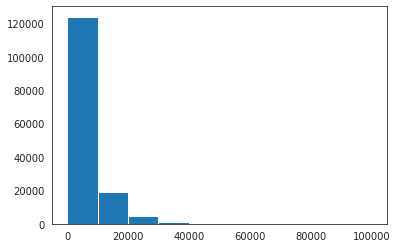

In [63]:
sub_Weighted = (1-MAE_lgb/(MAE_xgb+MAE_lgb))*subA_lgb+(1-MAE_xgb/(MAE_xgb+MAE_lgb))*subA_xgb

## 查看预测值的统计进行
plt.hist(Y_data)
plt.show()
plt.close()

In [64]:
# 预测结果,正态分布
submission = test[['SaleID']].copy()
submission['price'] = sub_Weighted
submission.shape

(50000, 2)

In [65]:
submission.to_csv('submission3.csv', index=False)